In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import imputena
import numpy as np
from pylab import rcParams
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns

from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from tsfresh.feature_selection.relevance import calculate_relevance_table

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from catboost import CatBoostRegressor

In [12]:
df = pd.read_excel('C:/Users/Poskrebyshev/JupyterNotebook/milk_forecasting/data_milk.xlsx').set_index('Date').rename(columns = {'Unnamed: 0':'id'})
df.index = pd.to_datetime(df.index)
df = df[:'2021-12-01']

In [13]:
df.head()

,id,USD/Rur,EUR/Rur,Inflation vs M-1,BU EU in €/Mt,SMP EU in €/Mt,EU CHEESE in €/Mt,Whey in €/Mt (Food),Butter Oceania in $/Mt,SMP Oceania in $/Mt,...,"Запасы сыр, тыс.тонн","Производство молочной продукции в пересчете на МЭ, тыс. тонн","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн",Индекс RMCI,"Цены на корма. Жмых подсолничниковые, руб/т","Цены на корма. Шрот подсолничниковые, руб/т","Цены на корма. Пшеница фуражная, руб/т","Цены на корма. Ячмень, руб/т",Year,Month
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,30.099272,42.260422,1.041723,2908.081828,1994.779927,3003.493306,724.848787,0.0,0.000000,...,20.027959,1518.308597,NaN,0.483233,NaN,NaN,3232.834872,2553.459412,2010,1
2010-02-01,1,29.412085,42.588543,0.973981,2984.864617,1981.888395,2907.039387,722.227880,0.0,0.000000,...,20.546038,1526.080663,NaN,0.486867,NaN,NaN,3297.459717,2359.929562,2010,2
2010-03-01,2,30.806371,40.839424,1.024281,2903.010858,1931.707922,2884.121591,712.099073,0.0,2736.721445,...,21.894121,1672.606957,NaN,0.469210,NaN,NaN,3235.447121,2192.799379,2010,3
2010-04-01,3,30.095126,40.992451,1.006000,3107.252402,2164.566484,2934.467635,738.353242,0.0,3819.923288,...,25.639925,1772.104395,NaN,0.466376,NaN,NaN,2958.597288,2155.341894,2010,4
2010-05-01,4,28.925031,37.093968,0.961909,3722.130286,2381.400845,3258.836135,825.011541,0.0,3506.898690,...,30.838285,1845.185599,NaN,0.498792,NaN,NaN,3007.526863,2601.986902,2010,5


In [14]:
df.tail()

,id,USD/Rur,EUR/Rur,Inflation vs M-1,BU EU in €/Mt,SMP EU in €/Mt,EU CHEESE in €/Mt,Whey in €/Mt (Food),Butter Oceania in $/Mt,SMP Oceania in $/Mt,...,"Запасы сыр, тыс.тонн","Производство молочной продукции в пересчете на МЭ, тыс. тонн","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн",Индекс RMCI,"Цены на корма. Жмых подсолничниковые, руб/т","Цены на корма. Шрот подсолничниковые, руб/т","Цены на корма. Пшеница фуражная, руб/т","Цены на корма. Ячмень, руб/т",Year,Month
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-01,139,73.398928,88.119759,1.005312,4071.869758,2610.022160,3670.607362,1057.491672,4543.909564,2859.848562,...,79.835432,2129.467033,785.528388,1.413713,23855.173597,20586.328933,13537.475436,12194.911461,2021,8
2021-09-01,140,71.991939,85.386522,1.019569,4266.825122,2633.833250,4010.976052,1119.129403,4737.097718,3179.357226,...,78.447088,2035.009079,723.241372,1.482577,19846.225535,19077.536423,14174.416754,13347.050955,2021,9
2021-10-01,141,74.450534,84.671607,1.031511,4797.347960,2831.639120,4072.957558,1120.631131,4903.437676,3306.678653,...,78.506803,2086.594768,788.315476,1.468735,21663.015811,18650.644892,14216.747239,13117.626403,2021,10
2021-11-01,142,73.876007,83.402398,0.966227,5467.476673,2983.740415,4144.254863,1128.298476,5170.755476,3639.058434,...,78.613405,2106.533464,792.696091,1.435401,21170.660926,18411.325319,14428.472295,14266.241509,2021,11
2021-12-01,143,72.231648,81.130262,1.005491,5935.561588,3132.693201,4451.721970,1191.754364,5727.399490,3554.000588,...,71.299175,2043.836685,773.556678,1.471378,21163.344247,17425.874847,15193.954081,13902.455840,2021,12


In [15]:
df.describe()

,id,USD/Rur,EUR/Rur,Inflation vs M-1,BU EU in €/Mt,SMP EU in €/Mt,EU CHEESE in €/Mt,Whey in €/Mt (Food),Butter Oceania in $/Mt,SMP Oceania in $/Mt,...,"Запасы сыр, тыс.тонн","Производство молочной продукции в пересчете на МЭ, тыс. тонн","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн",Индекс RMCI,"Цены на корма. Жмых подсолничниковые, руб/т","Цены на корма. Шрот подсолничниковые, руб/т","Цены на корма. Пшеница фуражная, руб/т","Цены на корма. Ячмень, руб/т",Year,Month
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,120.000000,144.000000,132.000000,132.000000,144.000000,144.000000,144.000000,144.000000
mean,71.500000,51.959491,61.522116,1.005529,3830.363471,2214.753748,3431.278228,913.776554,3083.191019,2813.173242,...,51.032224,1903.842708,811.564109,0.912902,12145.514680,11520.724983,8480.320991,7946.278006,2015.500000,6.500000
std,41.713307,17.675402,17.599969,0.028941,910.387387,499.406613,352.782071,140.018132,2003.766498,895.544050,...,12.865373,194.523048,45.008568,0.263570,5533.279056,5044.013295,2826.506128,2523.262535,3.464102,3.464102
min,0.000000,26.749481,37.093968,0.953254,2355.582020,1272.649695,2408.318636,568.911417,0.000000,0.000000,...,20.027959,1466.150977,723.241372,0.466376,2824.421333,2546.359211,2958.597288,2155.341894,2010.000000,1.000000
25%,35.750000,31.890678,41.703853,0.979989,3217.750177,1853.413130,3254.595953,820.750555,0.000000,2099.420315,...,41.606907,1772.553021,779.375205,0.698875,9120.555177,8439.742821,6352.129569,6153.283243,2012.750000,3.750000
50%,71.500000,58.732094,67.000807,1.006250,3680.918655,2165.250158,3459.135567,926.586014,3704.920406,2751.287027,...,50.430427,1912.289627,807.696439,0.958942,11124.913959,10650.639152,7989.722945,7745.247626,2015.500000,6.500000
75%,107.250000,66.681849,75.042547,1.027256,4195.875722,2541.283285,3626.557085,1029.704959,4550.495299,3434.943655,...,58.358025,2040.870880,831.809082,1.101410,14158.873973,13630.255205,10011.899126,9341.981412,2018.250000,9.250000
max,143.000000,80.009941,92.519885,1.069834,6964.098636,3320.098906,4451.721970,1191.754364,6271.031756,4888.207813,...,87.365260,2302.057391,967.808026,1.482577,31496.520809,27704.988991,15494.225875,14348.673834,2021.000000,12.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2010-01-01 to 2021-12-01
Data columns (total 37 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   id                                                                144 non-null    int64  
 1   USD/Rur                                                           144 non-null    float64
 2   EUR/Rur                                                           144 non-null    float64
 3   Inflation vs M-1                                                  144 non-null    float64
 4   BU EU in €/Mt                                                     144 non-null    float64
 5   SMP EU in €/Mt                                                    144 non-null    float64
 6   EU CHEESE in €/Mt                                                 144 non-null    float64
 7   Whey in €/Mt (Fo

In [17]:
df.drop_duplicates(inplace = True)

In [18]:
df.shape

(144, 37)

Text(0, 0.5, 'Цена за литр сырого молока')

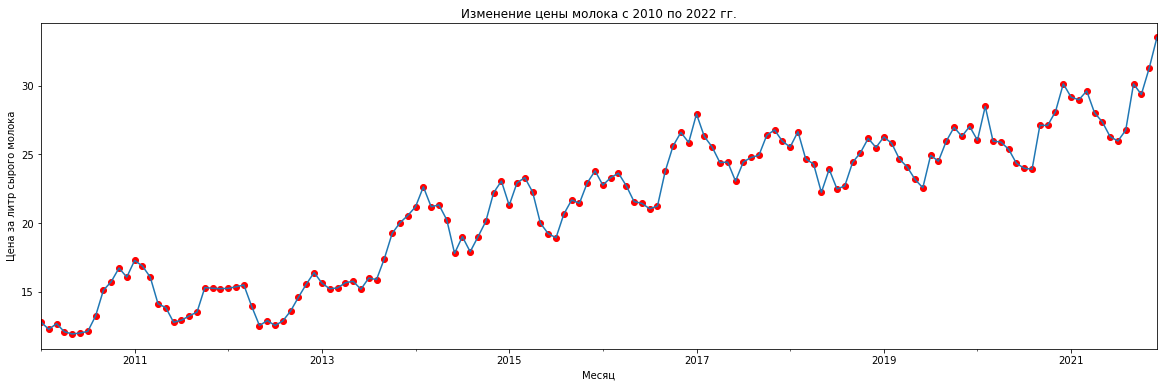

In [19]:
plt.figure(figsize=(20,6))
df['Ru milk price, rur/kg'].plot()
plt.scatter(df.index, df['Ru milk price, rur/kg'], color = 'red')
plt.title("Изменение цены молока с 2010 по 2022 гг.")
plt.xlabel("Месяц")
plt.ylabel("Цена за литр сырого молока")

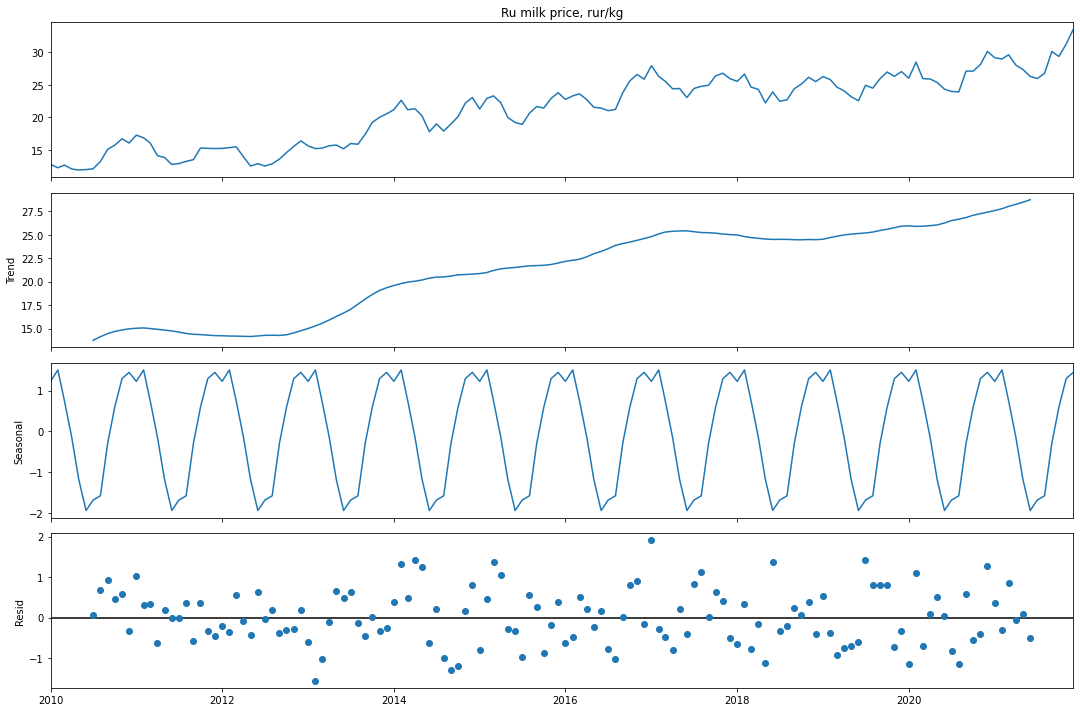

In [20]:
decompose = seasonal_decompose(df['Ru milk price, rur/kg'])
rcParams['figure.figsize'] = 15, 10
decompose.plot()
plt.show()

# Обработка пропущенных значений

In [21]:
print("Количество строк с пропущенными значениями:", df[df.isna().any(axis=1)].shape[1])

print("Количество строк с пропущенными значениями по столбцам:")
print(df.isna().sum()[df.isna().sum() > 0])

Количество строк с пропущенными значениями: 37
Количество строк с пропущенными значениями по столбцам:
Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн    24
Цены на корма. Жмых подсолничниковые, руб/т                         12
Цены на корма. Шрот подсолничниковые, руб/т                         12
dtype: int64


In [22]:
df[df.isna().any(axis=1)]

,id,USD/Rur,EUR/Rur,Inflation vs M-1,BU EU in €/Mt,SMP EU in €/Mt,EU CHEESE in €/Mt,Whey in €/Mt (Food),Butter Oceania in $/Mt,SMP Oceania in $/Mt,...,"Запасы сыр, тыс.тонн","Производство молочной продукции в пересчете на МЭ, тыс. тонн","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн",Индекс RMCI,"Цены на корма. Жмых подсолничниковые, руб/т","Цены на корма. Шрот подсолничниковые, руб/т","Цены на корма. Пшеница фуражная, руб/т","Цены на корма. Ячмень, руб/т",Year,Month
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,30.099272,42.260422,1.041723,2908.081828,1994.779927,3003.493306,724.848787,0.0,0.000000,...,20.027959,1518.308597,NaN,0.483233,NaN,NaN,3232.834872,2553.459412,2010,1
2010-02-01,1,29.412085,42.588543,0.973981,2984.864617,1981.888395,2907.039387,722.227880,0.0,0.000000,...,20.546038,1526.080663,NaN,0.486867,NaN,NaN,3297.459717,2359.929562,2010,2
2010-03-01,2,30.806371,40.839424,1.024281,2903.010858,1931.707922,2884.121591,712.099073,0.0,2736.721445,...,21.894121,1672.606957,NaN,0.469210,NaN,NaN,3235.447121,2192.799379,2010,3
2010-04-01,3,30.095126,40.992451,1.006000,3107.252402,2164.566484,2934.467635,738.353242,0.0,3819.923288,...,25.639925,1772.104395,NaN,0.466376,NaN,NaN,2958.597288,2155.341894,2010,4
2010-05-01,4,28.925031,37.093968,0.961909,3722.130286,2381.400845,3258.836135,825.011541,0.0,3506.898690,...,30.838285,1845.185599,NaN,0.498792,NaN,NaN,3007.526863,2601.986902,2010,5
2010-06-01,5,30.035802,39.366685,0.979430,3472.583393,2352.112866,3134.627267,724.495138,0.0,3460.780656,...,36.788755,1934.985797,NaN,0.480963,NaN,NaN,3074.300626,2475.498978,2010,6
2010-07-01,6,30.903262,40.695373,1.052615,3544.575669,2217.285403,3424.708163,700.275045,0.0,2974.995895,...,39.005470,1976.837945,NaN,0.481198,NaN,NaN,3796.932144,2946.088580,2010,7
2010-08-01,7,29.876373,41.168960,1.045097,3576.299475,2277.595175,3409.612349,753.732092,0.0,2700.570766,...,40.952312,1872.058664,NaN,0.493873,NaN,NaN,5738.708920,5353.825225,2010,8
2010-09-01,8,31.321326,38.626867,0.997995,3838.030526,2217.579037,3517.665476,824.204135,0.0,3195.296107,...,44.400598,1760.047163,NaN,0.547387,NaN,NaN,5951.258182,6166.297278,2010,9


In [23]:
df_imp = imputena.seasonal_interpolation(data = df,
                                                 columns = ['Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн',
                                                           'Цены на корма. Жмых подсолничниковые, руб/т',
                                                           'Цены на корма. Шрот подсолничниковые, руб/т'])

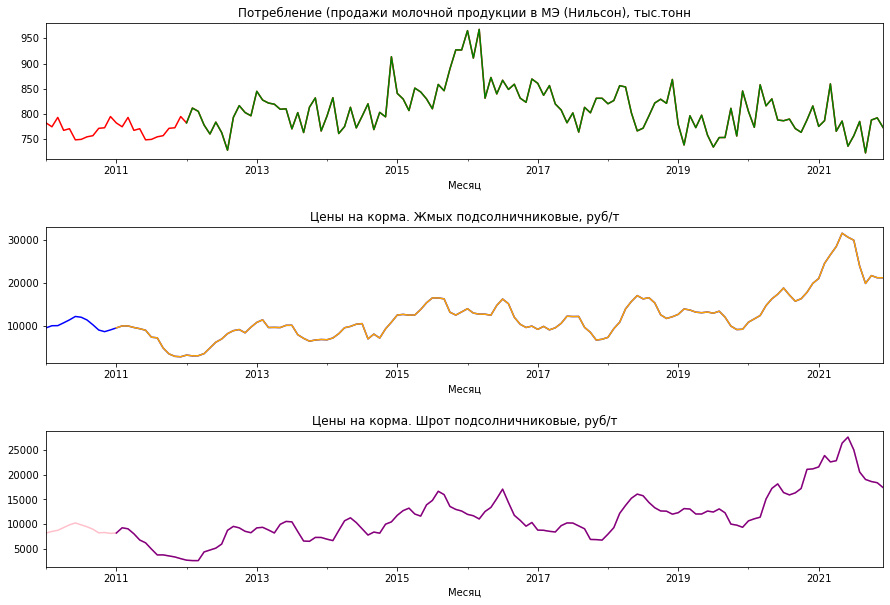

In [24]:
fig, axes = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

#1
df_imp['Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн'].plot(color='red', ax=axes[0])
df['Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн'].plot(color='green', ax=axes[0])

axes[0].set_title('Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн')
axes[0].set_xlabel("Месяц")

#2
df_imp['Цены на корма. Жмых подсолничниковые, руб/т'].plot(color='blue', ax=axes[1])
df['Цены на корма. Жмых подсолничниковые, руб/т'].plot(color='orange', ax=axes[1])

axes[1].set_title('Цены на корма. Жмых подсолничниковые, руб/т')
axes[1].set_xlabel("Месяц")

#3
df_imp['Цены на корма. Шрот подсолничниковые, руб/т'].plot(color='pink', ax=axes[2])
df['Цены на корма. Шрот подсолничниковые, руб/т'].plot(color='purple', ax=axes[2])

axes[2].set_title('Цены на корма. Шрот подсолничниковые, руб/т')
axes[2].set_xlabel("Месяц")

plt.show()

# Формирование датасета посчитанных фичей с использованием tsfresh

In [25]:
X = df_imp.drop(['Ru milk price, rur/kg'], axis = 1)
y = df_imp['Ru milk price, rur/kg']

In [26]:
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings.MinimalFCParameters())

In [27]:
X_tsfreshed = extract_features(X, column_id='id',
                     default_fc_parameters=settings_time,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)
X_tsfreshed.index = y.index

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.68it/s]


In [28]:
np.object = object
relevance_table = calculate_relevance_table(X_tsfreshed, y).sort_values(by='p_value', ascending=True)
relevant_features = relevance_table[relevance_table.relevant == True].index
X_tsfreshed_filtered = X_tsfreshed[relevant_features]

In [29]:
print('X_tsfreshed shape:', X_tsfreshed.shape)
print('X_tsfreshed_filtered shape:', X_tsfreshed_filtered.shape)

X_tsfreshed shape: (144, 490)
X_tsfreshed_filtered shape: (144, 180)


In [30]:
X_tsfreshed_filtered.describe()

,Индекс RMCI__median,Индекс RMCI__root_mean_square,Индекс RMCI__mean,Индекс RMCI__sum_values,Индекс RMCI__maximum,Индекс RMCI__minimum,Year__sum_values,Year__minimum,Year__maximum,Year__root_mean_square,...,"Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн__median","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн__minimum","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн__mean","Потребление (продажи молочной продукции в МЭ (Нильсон), тыс.тонн__maximum",SMP Oceania in $/Mt__minimum,SMP Oceania in $/Mt__maximum,SMP Oceania in $/Mt__mean,SMP Oceania in $/Mt__median,SMP Oceania in $/Mt__sum_values,SMP Oceania in $/Mt__root_mean_square
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,0.912902,0.912902,0.912902,0.912902,0.912902,0.912902,2015.500000,2015.500000,2015.500000,2015.500000,...,804.667283,804.667283,804.667283,804.667283,2813.173242,2813.173242,2813.173242,2813.173242,2813.173242,2813.173242
std,0.263570,0.263570,0.263570,0.263570,0.263570,0.263570,3.464102,3.464102,3.464102,3.464102,...,44.292239,44.292239,44.292239,44.292239,895.544050,895.544050,895.544050,895.544050,895.544050,895.544050
min,0.466376,0.466376,0.466376,0.466376,0.466376,0.466376,2010.000000,2010.000000,2010.000000,2010.000000,...,723.241372,723.241372,723.241372,723.241372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.698875,0.698875,0.698875,0.698875,0.698875,0.698875,2012.750000,2012.750000,2012.750000,2012.750000,...,772.215049,772.215049,772.215049,772.215049,2099.420315,2099.420315,2099.420315,2099.420315,2099.420315,2099.420315
50%,0.958942,0.958942,0.958942,0.958942,0.958942,0.958942,2015.500000,2015.500000,2015.500000,2015.500000,...,796.719515,796.719515,796.719515,796.719515,2751.287027,2751.287027,2751.287027,2751.287027,2751.287027,2751.287027
75%,1.101410,1.101410,1.101410,1.101410,1.101410,1.101410,2018.250000,2018.250000,2018.250000,2018.250000,...,830.086976,830.086976,830.086976,830.086976,3434.943655,3434.943655,3434.943655,3434.943655,3434.943655,3434.943655
max,1.482577,1.482577,1.482577,1.482577,1.482577,1.482577,2021.000000,2021.000000,2021.000000,2021.000000,...,967.808026,967.808026,967.808026,967.808026,4888.207813,4888.207813,4888.207813,4888.207813,4888.207813,4888.207813


# Обучение моделей и оценка результатов

In [31]:
X_filtered_train, X_filtered_test = X_tsfreshed_filtered[:'2020-12-31'], X_tsfreshed_filtered['2021-01-01':]
y_train, y_test = y[:'2020-12-31'], y['2021-01-01':]

## Linear Regression

In [32]:
X_filtered_train_reg = sm.add_constant(X_filtered_train, prepend=False)
model_OLS = OLS(y_train.values.reshape(-1,1), X_filtered_train_reg)
OLS_fit_res = model_OLS.fit()
print(OLS_fit_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     83.75
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           1.40e-58
Time:                        18:59:30   Log-Likelihood:                -183.05
No. Observations:                 132   AIC:                             428.1
Df Residuals:                     101   BIC:                             517.5
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [33]:
X_filtered_test_reg = sm.add_constant(X_filtered_test, prepend=False, has_constant='add')
y_OLS = OLS_fit_res.predict(X_filtered_test_reg)

print('MSE: %2f' % mean_squared_error(y_test, y_OLS))
print('MAE: %2f' % mean_absolute_error(y_test, y_OLS))
print('R2: %2f' % r2_score(y_test, y_OLS))

MSE: 2.392166
MAE: 1.109870
R2: 0.449241


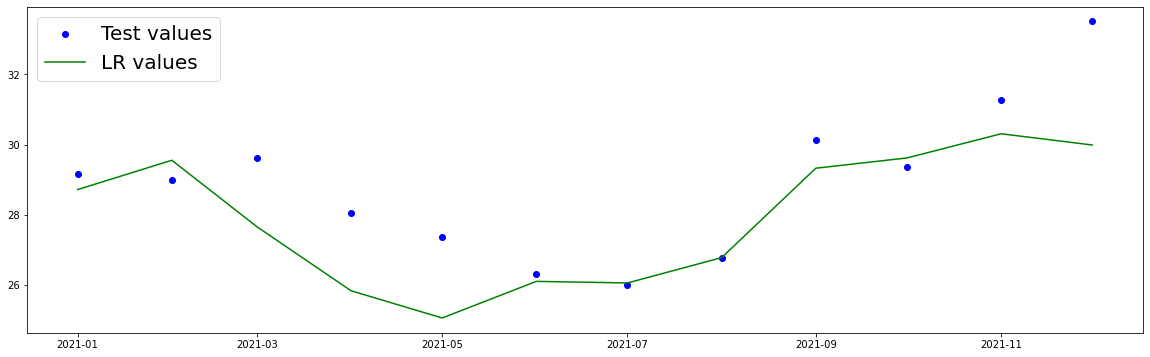

In [52]:
plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, color = 'blue')
plt.plot(y_OLS, color = 'green')
plt.legend(['Test values', 'LR values'], prop={'size': 20})

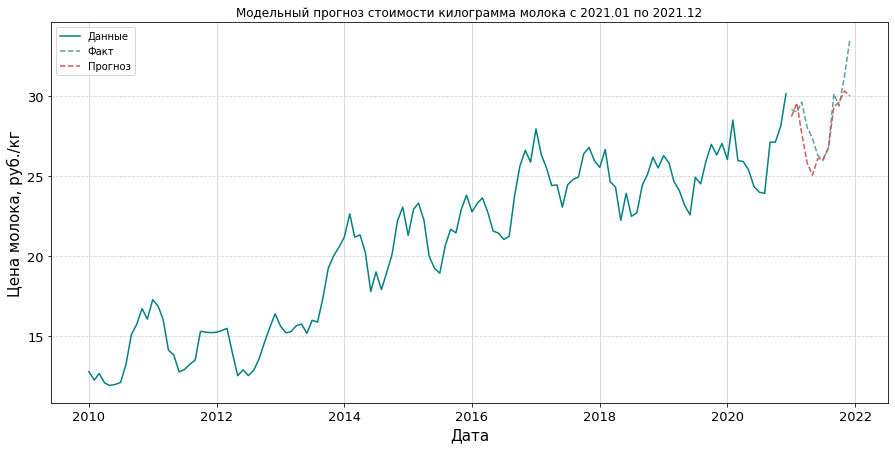

In [50]:
plt.figure(figsize=[15, 7])

plt.plot(y_train, label='Данные', color='teal')
plt.plot(y_test, label='Факт', color='cadetblue', linestyle='--')
plt.plot(y_test.index, y_OLS, label='Прогноз', color='indianred', linestyle='--')


plt.title('Модельный прогноз стоимости килограмма молока с 2021.01 по 2021.12')
plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Цена молока, руб./кг', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)

plt.legend()

## Random Forest

In [35]:
RFR_parameters = {'n_estimators':[15, 20, 25, 30],
                  'criterion': ['squared_error', 'absolute_error'],
                  'max_depth': [25, 30, 35, 40, 45],
                  'min_samples_split': [3, 5],
                  'min_samples_leaf': [2, 3]}
clf_RFR = GridSearchCV(RandomForestRegressor(), RFR_parameters)

In [36]:
RFR_fit_res = clf_RFR.fit(X_filtered_train, y_train)
print('Best parameters:')
print(RFR_fit_res.best_params_)

Best parameters:
{'criterion': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 15}


In [37]:
y_RFR = RFR_fit_res.best_estimator_.predict(X_filtered_test)
y_RFR = pd.DataFrame(data = y_RFR, index = y_test.index)

print('MSE: %2f' % mean_squared_error(y_test, y_RFR))
print('MAE: %2f' % mean_absolute_error(y_test, y_RFR))
print('R2: %2f' % r2_score(y_test, y_RFR))

MSE: 8.077990
MAE: 2.285403
R2: -0.859833


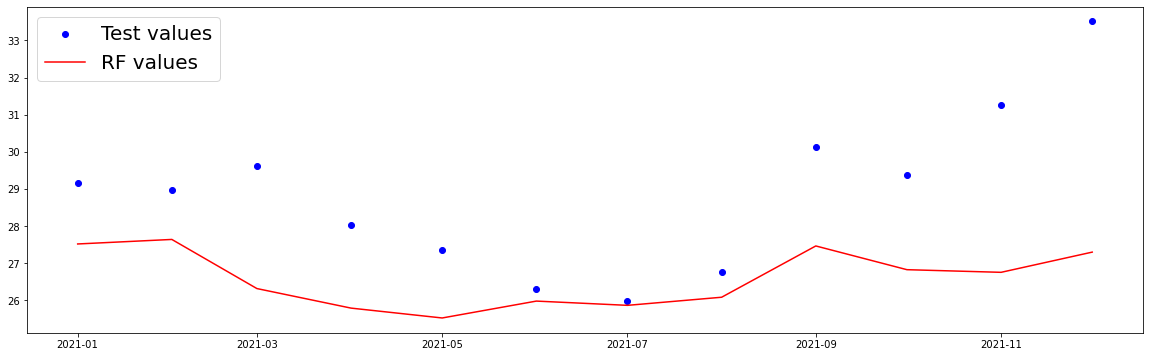

In [38]:
plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, color = 'blue')
plt.plot(y_RFR, color = 'red')
plt.legend(['Test values', 'RF values'], prop={'size': 20})

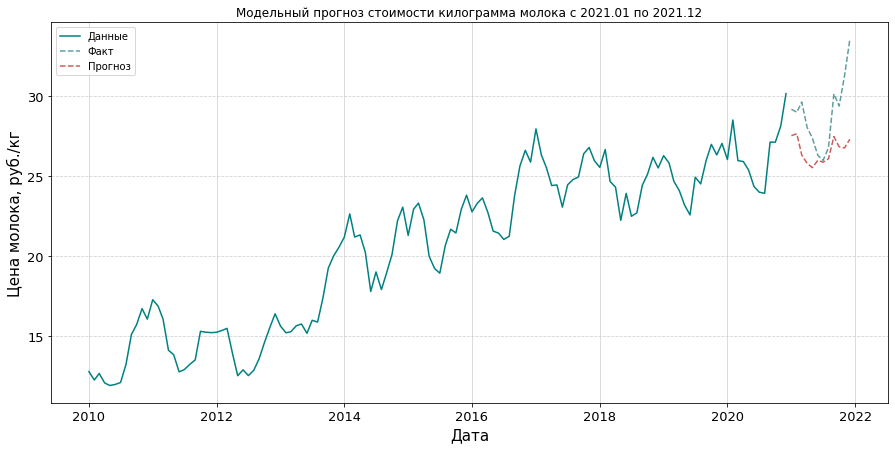

In [60]:
plt.figure(figsize=[15, 7])

plt.plot(y_train, label='Данные', color='teal')
plt.plot(y_test, label='Факт', color='cadetblue', linestyle='--')
plt.plot(y_test.index, y_RFR.values, label='Прогноз', color='indianred', linestyle='--')


plt.title('Модельный прогноз стоимости килограмма молока с 2021.01 по 2021.12')
plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Цена молока, руб./кг', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)

plt.legend()

## XGBoost

In [39]:
XGBoost_parameters = {'n_estimators': [100, 300, 500],
                      'max_depth': [6, 8, 10, 12, 15, 20],
                      'eta': [0.3, 0.1, 0.01],
                      'subsample': [1],
                      'colsample_bytree': [1]
                    }
clf_XGBoost = GridSearchCV(XGBRegressor(), XGBoost_parameters)

In [40]:
XGBoost_fit_res = clf_XGBoost.fit(X_filtered_train, y_train)
print('Best parameters:')
print(XGBoost_fit_res.best_params_)

Best parameters:
{'colsample_bytree': 1, 'eta': 0.3, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1}


In [41]:
y_XGBoost = XGBoost_fit_res.best_estimator_.predict(X_filtered_test)
y_XGBoost = pd.DataFrame(data = y_XGBoost, index = y_test.index)

print('MSE: %2f' % mean_squared_error(y_test, y_XGBoost))
print('MAE: %2f' % mean_absolute_error(y_test, y_XGBoost))
print('R2: %2f' % r2_score(y_test, y_XGBoost))

MSE: 9.596987
MAE: 2.809106
R2: -1.209559


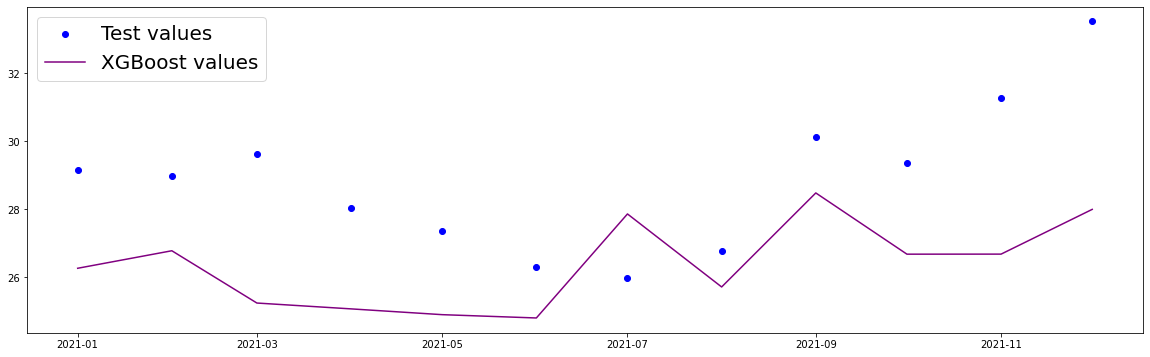

In [42]:
plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, color = 'blue')
plt.plot(y_XGBoost, color = 'purple')
plt.legend(['Test values', 'XGBoost values'], prop={'size': 20})

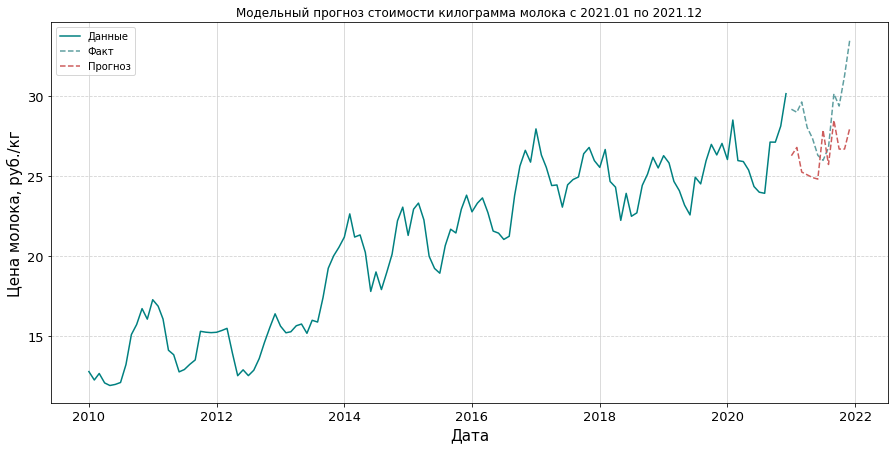

In [62]:
plt.figure(figsize=[15, 7])

plt.plot(y_train, label='Данные', color='teal')
plt.plot(y_test, label='Факт', color='cadetblue', linestyle='--')
plt.plot(y_test.index, y_XGBoost.values, label='Прогноз', color='indianred', linestyle='--')


plt.title('Модельный прогноз стоимости килограмма молока с 2021.01 по 2021.12')
plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Цена молока, руб./кг', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)

plt.legend()

## Support Vector Regression

In [43]:
SVR_parameters = {'kernel': ['poly', 'rbf', 'sigmoid'],
                  'degree': [1, 2, 3, 4 , 5],
                  'C': [1, 1.5, 2, 5],
                  'cache_size': [512],
                    }

In [44]:
clf_SVR = GridSearchCV(SVR(), SVR_parameters)

In [45]:
SVR_fit_res = clf_SVR.fit(X_filtered_train, y_train)
print('Best parameters:')
print(SVR_fit_res.best_params_)

Best parameters:
{'C': 5, 'cache_size': 512, 'degree': 2, 'kernel': 'poly'}


In [46]:
y_SVR = SVR_fit_res.best_estimator_.predict(X_filtered_test)
y_SVR = pd.DataFrame(data = y_SVR, index = y_test.index)

print('MSE: %2f' % mean_squared_error(y_test, y_SVR))
print('MAE: %2f' % mean_absolute_error(y_test, y_SVR))
print('R2: %2f' % r2_score(y_test, y_SVR))

MSE: 2.970698
MAE: 1.482021
R2: 0.316043


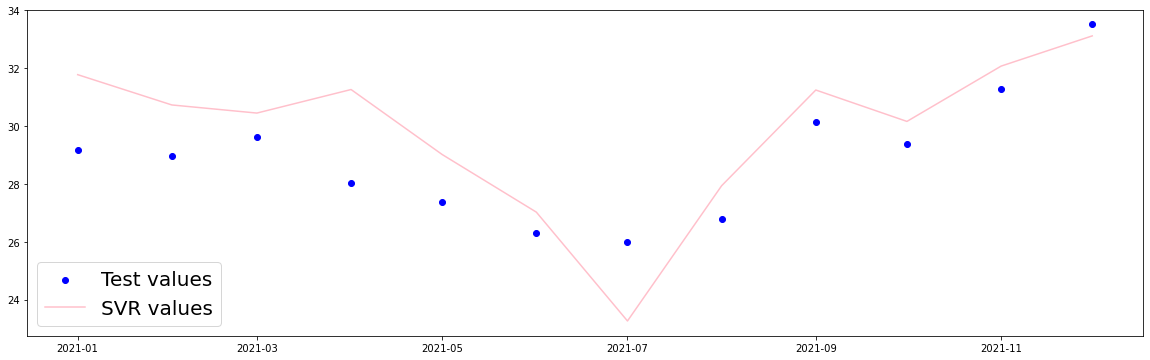

In [47]:
plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, color = 'blue')
plt.plot(y_SVR, color = 'pink')
plt.legend(['Test values', 'SVR values'], prop={'size': 20})

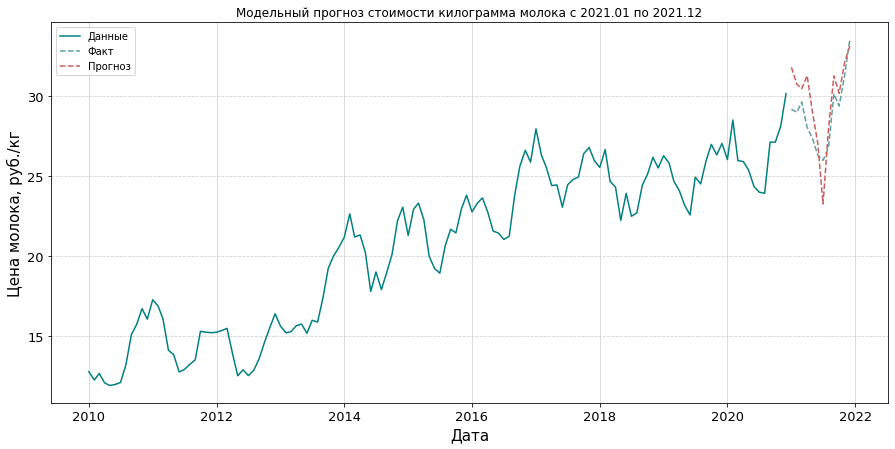

In [64]:
plt.figure(figsize=[15, 7])

plt.plot(y_train, label='Данные', color='teal')
plt.plot(y_test, label='Факт', color='cadetblue', linestyle='--')
plt.plot(y_test.index, y_SVR.values, label='Прогноз', color='indianred', linestyle='--')


plt.title('Модельный прогноз стоимости килограмма молока с 2021.01 по 2021.12')
plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Цена молока, руб./кг', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)

plt.legend()

## CatBoost

In [325]:
CBoost_parameters = {'iterations': [300, 400, 500],
                     'loss_function': ['RMSE'],
                     'verbose': [False],
                     'learning_rate': [0.03, 0.1, 0.15, 0.2],
                     'depth': [4, 6, 10],
                     'l2_leaf_reg': [3, 5, 7]
                    }
clf_CBoost = GridSearchCV(CatBoostRegressor(), CBoost_parameters)

In [75]:
CBoost_fit_res = clf_CBoost.fit(X_filtered_train, y_train)
print('Best parameters:')
print(CBoost_fit_res.best_params_)

Best parameters:
{'depth': 4, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.2, 'loss_function': 'RMSE', 'verbose': False}


In [76]:
y_CBoost = CBoost_fit_res.best_estimator_.predict(X_filtered_test)
y_CBoost = pd.DataFrame(data = y_CBoost, index = y_test.index)

print('MSE: %2f' % mean_squared_error(y_test, y_CBoost))
print('MAE: %2f' % mean_absolute_error(y_test, y_CBoost))
print('R2: %2f' % r2_score(y_test, y_CBoost))

MSE: 4.658444
MAE: 1.657235
R2: -0.072535


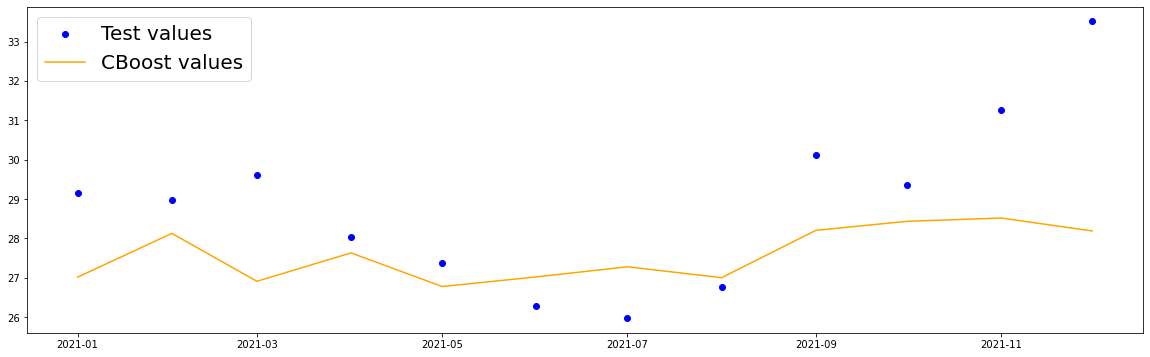

In [68]:
plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, color = 'blue')
plt.plot(y_CBoost, color = 'orange')
plt.legend(['Test values', 'CBoost values'], prop={'size': 20})

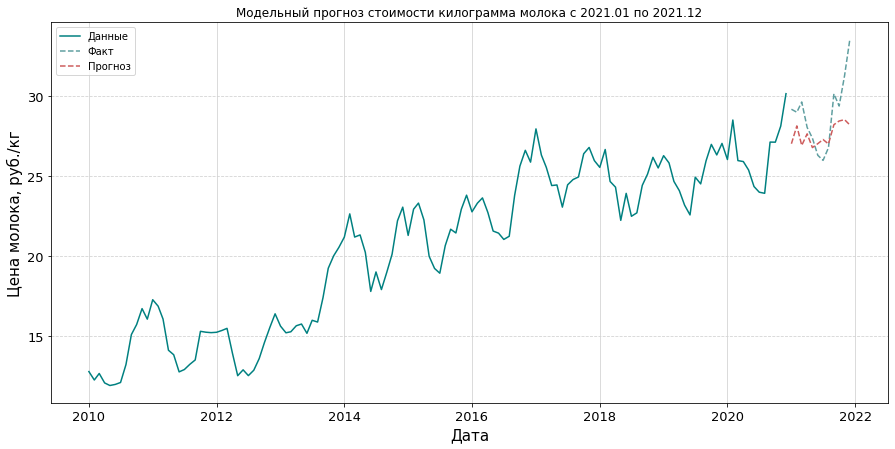

In [69]:
plt.figure(figsize=[15, 7])

plt.plot(y_train, label='Данные', color='teal')
plt.plot(y_test, label='Факт', color='cadetblue', linestyle='--')
plt.plot(y_test.index, y_CBoost.values, label='Прогноз', color='indianred', linestyle='--')


plt.title('Модельный прогноз стоимости килограмма молока с 2021.01 по 2021.12')
plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Цена молока, руб./кг', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)

plt.legend()

# Сравнение результатов моделей

In [10]:
results = pd.DataFrame({'Model': ['LR', 'RF', 'XGBoost', 'SVR', 'CatBoost'],
                       'MAE': [1.109870, 2.293928, 2.809106, 1.482021, 1.657235],
                       'MSE': [2.392166, 8.492593, 9.596987, 2.970698, 4.658444],
                       'R^2': [0.449241, -0.955289, -1.209559, 0.316043, -0.072535]})
results.index = results.Model
results.drop(columns = 'Model', axis = 0, inplace = True)
results

,MAE,MSE,R^2
Model,,,
LR,1.109870,2.392166,0.449241
RF,2.293928,8.492593,-0.955289
XGBoost,2.809106,9.596987,-1.209559
SVR,1.482021,2.970698,0.316043
CatBoost,1.657235,4.658444,-0.072535
